# Створення нейронної мережі

У цьому завданні ми створимо повнозв'язну нейронну мережу, використовуючи при цьому низькорівневі механізми tensorflow.

Архітектура нейромережі представлена на наступному малюнку. Як бачиш, у ній є один вхідний шар, два приховані, а також вихідний шар. В якості активаційної функції у прихованих шарах буде використовуватись сигмоїда. На вихідному шарі ми використовуємо softmax.

Частина коду зі створення мережі вже написана, тобі потрібно заповнити пропуски у вказаних місцях.

## Архітектура нейронної мережі

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## Про датасет MNIST

Дану нейромережу ми будемо вивчати на датасеті MNIST. Цей датасет являє собою велику кількість зображень рукописних цифр розміром $28 \times 28$ пікселів. Кожен піксель приймає значення від 0 до 255.

Як і раніше, датасет буде розділений на навчальну та тестову вибірки. При цьому ми виконаємо нормалізацію всіх зображень, щоб значення пікселів знаходилось у проміжку від 0 до 1, розділивши яскравість кожного пікселя на 255.

Окрім того, архітектура нейронної мережі очікує на вхід вектор. У нашому ж випадку кожен об'єкт вибірки являє собою матрицю. Що ж робити? У цьому завданні ми "розтягнемо" матрицю $28 \times 28$, отримавши при цьому вектор, що складається з 784 елементів.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Більше інформації про датасет можна знайти [тут](http://yann.lecun.com/exdb/mnist/).

In [53]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import keras as K
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tabulate import tabulate

#from tensorflow.keras.datasets import mnist
from keras.datasets import mnist

In [54]:
print(tf.__version__)

2.15.0


In [55]:
num_classes = 10 # загальна кількість класів, у нашому випадку це цифри від 0 до 9
num_features = 784 # кількість атрибутів вхідного вектора 28 * 28 = 784

# img_shape = (28, 28, 1) # форма зображення

# learning_rate = 0.01 # швидкість навчання нейронної мережі
learning_rate = 0.001 # швидкість навчання нейронної мережі
# training_steps = 3000 # максимальне число епох
# training_steps = 5000 # максимальне число епох
training_steps = 4800 # максимальне число епох

batch_size = 256 # перераховувати ваги мережі ми будемо не на всій вибірці, а на її випадковій підмножині з batch_size елементів
display_step = 100 # кожні 100 ітерацій ми будемо показувати поточне значення функції втрат і точності

n_hidden_1 = 128 # кількість нейронів 1-го шару
n_hidden_2 = 256 # кількість нейронів 2-го шару
# n_hidden_3 = 512 # кількість нейронів 3-го шару


In [56]:


# Завантажуємо датасет
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Перетворюємо цілочисельні пікселі на тип float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Перетворюємо матриці розміром 28x28 пікселів у вектор з 784 елементів
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Нормалізуємо значення пікселів
x_train, x_test = x_train / 255., x_test / 255.

# Перемішаємо тренувальні дані
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)


In [57]:
# Створимо нейронну мережу

class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
                #  , activation, name=None, regularizer=None):
        super().__init__(name=name)
        self.w = tf.Variable(
            tf.random.normal([in_features, out_features]), name="w"
        )
        self.b = tf.Variable(tf.zeros([out_features]), name="b")
        # self.activation = activation
        # self.regularizer = regularizer

    def __call__(self, x, activation=0):
        y = tf.matmul(x, self.w) + self.b
        # if activation != 0:
        if activation == 'softmax':
            return tf.nn.softmax(y)
        if activation == 'sigmoid':
            return tf.nn.sigmoid(y)
        if activation == 'relu':
            return tf.nn.relu(y)
        if activation == 'leaky_relu':
            return tf.nn.leaky_relu(y)
        return y


class NN(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)
    # Перший шар, який складається з 128 нейронів
    self.layer1 = DenseLayer(num_features, n_hidden_1)
                             #, activation=tf.nn.leaky_relu)
                            #  ,regularizer=tf.keras.regularizers.L2(0.01))
    # Другий шар, який складається з 256 нейронів
    self.layer2 = DenseLayer(n_hidden_1, n_hidden_2)
                            # , activation=tf.nn.leaky_relu)
                            #  ,regularizer=tf.keras.regularizers.L2(0.01))
    # # Третій шар, який складається з 512 нейронів
    # self.layer3 = DenseLayer(n_hidden_2, n_hidden_3,
    #                          activation=tf.nn.leaky_relu,
    #                          regularizer=tf.keras.regularizers.L2(0.01))
    # Вихідний шар
    self.out_layer = DenseLayer(n_hidden_2, num_classes)
                                #,activation=tf.nn.softmax)



  def __call__(self, x):
    # # Передача даних через перші три шари та вихідний шар з функцією активації softmax
    # x = self.layer1(x)
    # x = self.layer2(x)
    # x = self.layer3(x)
    # return self.out_layer(x)
    x = self.layer1(x, activation='relu')
    x = self.layer2(x, activation='sigmoid')
    # x = self.layer2(x, activation='relu')
    x = self.out_layer(x, activation='softmax')
    return x

In [58]:
# В якості функції помилки в даному випадку зручно взяти крос-ентропію
def cross_entropy(y_pred, y_true):
    # Закодувати label в one hot vector
    y_true = tf.one_hot(y_true, depth=num_classes)

    # Значення передбачення, щоб уникнути помилки log(0).
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    # Обчислення крос-ентропії
    # return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred), axis=1))

# Як метрику якості використовуємо точність
def accuracy(y_pred, y_true):
    # Порівнюємо передбачення та істинні значення
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64))
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    # return tf.reduce_mean(tf.cast(correct_prediction, tf.float32), axis=-1)

In [59]:
# Створимо екземпляр нейронної мережі
neural_net = NN(name="mnist")

# Функція навчання нейромережі
def train(neural_net, input_x, output_y):
  # Для налаштування вагів мережі будемо використовувати стохастичний градієнтний спуск
  # optimizer = tf.optimizers.SGD(learning_rate)
  # optimizer = tf.optimizers.Adam(learning_rate=0.001)
  optimizer = tf.optimizers.Adam(learning_rate)

  # Активація автоматичного диференціювання
  with tf.GradientTape() as g:
    pred = neural_net(input_x)
    loss = cross_entropy(pred, output_y)
    # reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
    # loss += tf.reduce_sum(reg_losses)

  # Отримаємо список оптимізованих параметрів
  trainable_variables = neural_net.trainable_variables

  # Обчислимо за ними значення градієнта
  gradients = g.gradient(loss, trainable_variables)

  # Модифікуємо параметри
  optimizer.apply_gradients(zip(gradients, trainable_variables))
  return loss

In [60]:
# Тренування мережі

loss_history = []  # кожні display_step кроків зберігай в цьому списку поточну помилку нейромережі
accuracy_history = [] # кожні display_step кроків зберігай в цьому списку поточну точність нейромережі

# У цьому циклі ми будемо проводити навчання нейронної мережі
# із тренувального датасета train_data вилучи випадкову підмножину, на якій
# відбудеться тренування. Використовуй метод take, доступний для тренувального датасета.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):

    loss = train(neural_net, batch_x, batch_y)

    if step % display_step == 0:
        pred = neural_net(batch_x)
        current_loss = loss.numpy()
        # Перетворення batch_y на int32 перед обчисленням точності
        current_accuracy = accuracy(pred, tf.cast(batch_y, tf.int64)).numpy()
        loss_history.append(current_loss)
        accuracy_history.append(current_accuracy)
        print(f"Step {step}, Loss: {current_loss:.4f}, Accuracy: {current_accuracy:.4f}")



Step 100, Loss: 3.8394, Accuracy: 0.4766
Step 200, Loss: 2.0154, Accuracy: 0.6719
Step 300, Loss: 1.4166, Accuracy: 0.7617
Step 400, Loss: 1.3303, Accuracy: 0.7656
Step 500, Loss: 1.2593, Accuracy: 0.7773
Step 600, Loss: 1.1595, Accuracy: 0.8242
Step 700, Loss: 0.8502, Accuracy: 0.8477
Step 800, Loss: 1.2748, Accuracy: 0.8203
Step 900, Loss: 0.7593, Accuracy: 0.8594
Step 1000, Loss: 0.8124, Accuracy: 0.8750
Step 1100, Loss: 0.7349, Accuracy: 0.8594
Step 1200, Loss: 0.7855, Accuracy: 0.8828
Step 1300, Loss: 0.6875, Accuracy: 0.8789
Step 1400, Loss: 0.3945, Accuracy: 0.9180
Step 1500, Loss: 0.4957, Accuracy: 0.9180
Step 1600, Loss: 0.5792, Accuracy: 0.9102
Step 1700, Loss: 0.3571, Accuracy: 0.9219
Step 1800, Loss: 0.5816, Accuracy: 0.9219
Step 1900, Loss: 0.6720, Accuracy: 0.8828
Step 2000, Loss: 0.4595, Accuracy: 0.9062
Step 2100, Loss: 0.3844, Accuracy: 0.9336
Step 2200, Loss: 0.4193, Accuracy: 0.9258
Step 2300, Loss: 0.4113, Accuracy: 0.9336
Step 2400, Loss: 0.4935, Accuracy: 0.9336
S

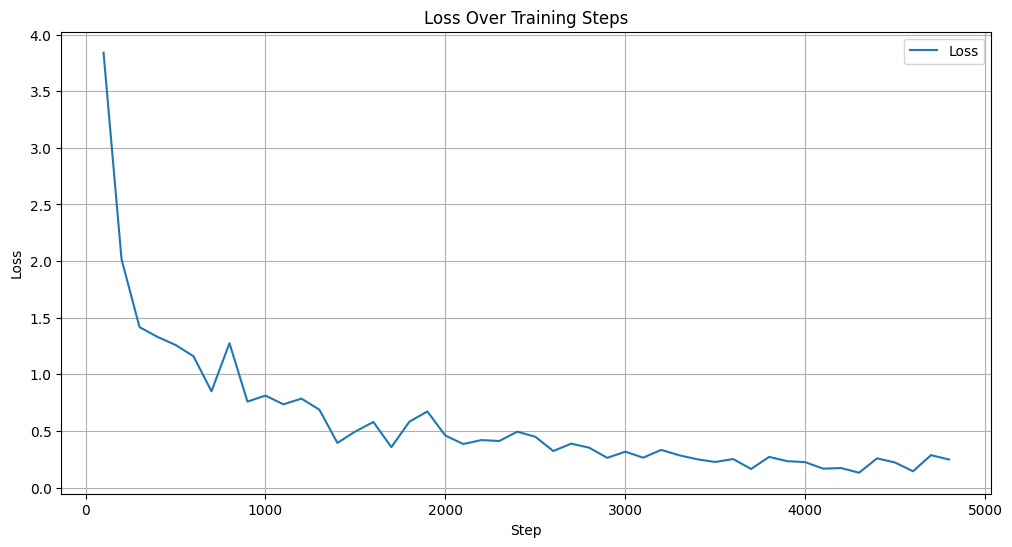

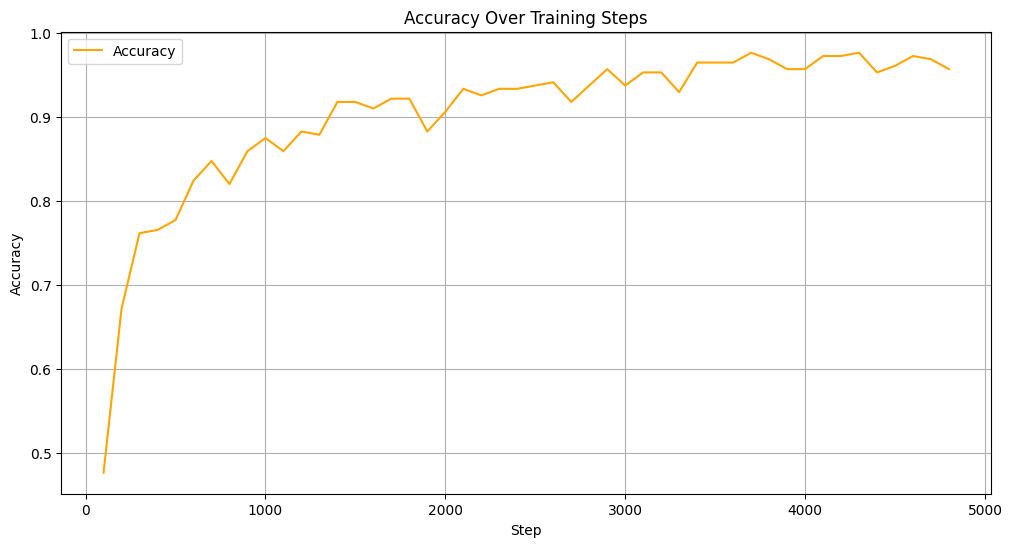

In [61]:
# Виведіть графіки залежності зміни точності і втрат від кроку
# Якщо все зроблено правильно, то точність повинна зростати, а втрати зменшуватись

import matplotlib.pyplot as plt

# Виведення графіка функції втрат
plt.figure(figsize=(12, 6))
plt.plot(range(display_step, training_steps + 1, display_step), loss_history, label='Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Loss Over Training Steps')
plt.legend()
plt.grid(True)
plt.show()

# Виведення графіка точності
plt.figure(figsize=(12, 6))
plt.plot(range(display_step, training_steps + 1, display_step), accuracy_history, label='Accuracy', color='orange')
plt.xlabel('Step')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Training Steps')
plt.legend()
plt.grid(True)
plt.show()


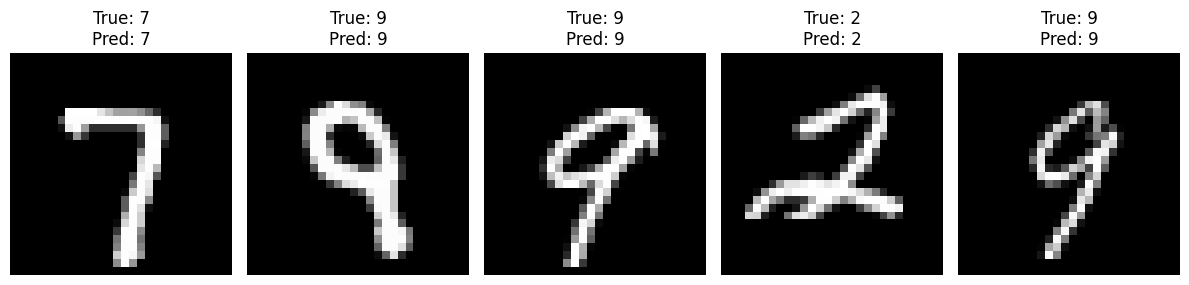

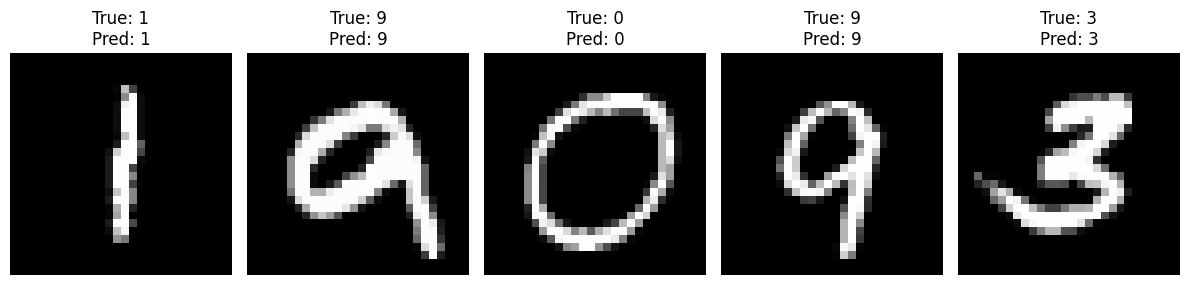

Correct predictions for first set: 5/5
Incorrect predictions for first set: 0/5
Correct predictions for second set: 5/5
Incorrect predictions for second set: 0/5


In [62]:
# Протестуйте навчену нейромережу на 10 зображеннях. З тестової вибірки візьміть 5
# випадкових зображень і передайте їх у нейронну мережу.
# Виведіть зображення та випишіть  поруч відповідь нейромережі.
# Зробіть висновок про те, чи помиляється твоя нейронна мережа, і якщо так, то як часто?

# import random
import matplotlib.pyplot as plt

# Вибираємо 5 випадкових зображень із тестової вибірки
random_indices = random.sample(range(x_test.shape[0]), 5)
random_images = x_test[random_indices]
random_labels = y_test[random_indices]

# Передаємо ці зображення до нейронної мережі
predictions = neural_net(random_images)
predicted_labels = tf.argmax(predictions, axis=1).numpy()

# Виведемо зображення та відповідь нейромережі
plt.figure(figsize=(12, 6))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(random_images[i].reshape(28, 28), cmap='gray')
    plt.title(f"True: {random_labels[i]}\nPred: {predicted_labels[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

# Аналогічно, для інших 5 зображень із тестової вибірки
additional_indices = random.sample(range(x_test.shape[0]), 5)
additional_images = x_test[additional_indices]
additional_labels = y_test[additional_indices]

# Передаємо ці зображення до нейронної мережі
additional_predictions = neural_net(additional_images)
additional_predicted_labels = tf.argmax(additional_predictions, axis=1).numpy()

# Виведемо зображення та відповідь нейромережі
plt.figure(figsize=(12, 6))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(additional_images[i].reshape(28, 28), cmap='gray')
    plt.title(f"True: {additional_labels[i]}\nPred: {additional_predicted_labels[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

# Зробіть висновок про те, чи помиляється нейронна мережа, і якщо так, то як часто
correct_predictions = np.sum(predicted_labels == random_labels)
incorrect_predictions = 5 - correct_predictions

additional_correct_predictions = np.sum(additional_predicted_labels == additional_labels)
additional_incorrect_predictions = 5 - additional_correct_predictions

print(f"Correct predictions for first set: {correct_predictions}/5")
print(f"Incorrect predictions for first set: {incorrect_predictions}/5")

print(f"Correct predictions for second set: {additional_correct_predictions}/5")
print(f"Incorrect predictions for second set: {additional_incorrect_predictions}/5")

In [63]:
from sklearn.metrics import classification_report
y_pred = neural_net(x_test)
y_pred_labels = tf.argmax(y_pred, axis=1).numpy()
report = classification_report(y_test, y_pred_labels, target_names=[str(i) for i in range(num_classes)])

print(report)

              precision    recall  f1-score   support

           0       0.95      0.97      0.96       980
           1       0.97      0.98      0.98      1135
           2       0.91      0.92      0.91      1032
           3       0.91      0.89      0.90      1010
           4       0.93      0.91      0.92       982
           5       0.91      0.90      0.90       892
           6       0.95      0.93      0.94       958
           7       0.92      0.93      0.92      1028
           8       0.87      0.88      0.87       974
           9       0.89      0.90      0.89      1009

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



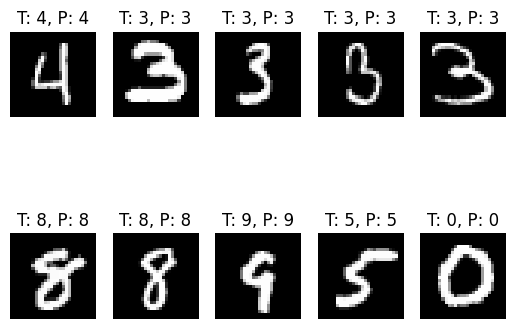

In [64]:
# Протестуйте навчену нейромережу на 10 зображеннях. З тестової вибірки візьміть 5
# випадкових зображень і передайте їх у нейронну мережу.
# Виведіть зображення та випишіть  поруч відповідь нейромережі.
# Зробіть висновок про те, чи помиляється твоя нейронна мережа, і якщо так, то як часто?

num_images = 10
test_images = random.sample(list(zip(x_test, y_test)), num_images)
for i, (image, label) in enumerate(test_images):
    image = image.reshape(1, -1)
    pred = neural_net(image)
    pred_label = tf.argmax(pred, axis=1).numpy()[0]
    plt.subplot(2, 5, i+1)
    plt.imshow(image.reshape(28, 28), cmap='gray')
    plt.title(f"T: {label}, P: {pred_label}")
    plt.axis('off')
plt.show()




Модель працює дуже добре і має високу точність та якість класифікації для більшості класів.